
--- Running Pipeline: R=-0.04, Gamma=0.99 ---
Value Iteration converged after 13 iterations (max change: 0.000048)


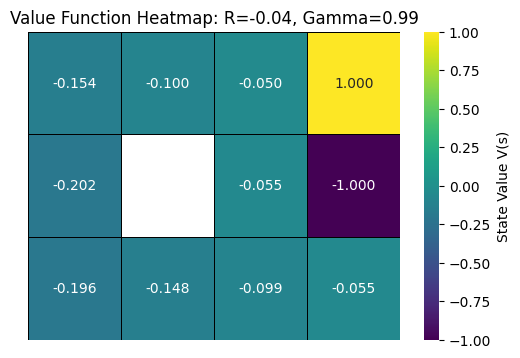

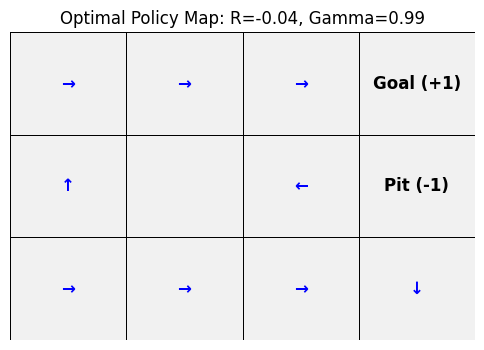


--- Running Pipeline: R=0.0, Gamma=0.99 ---
Value Iteration converged after 1 iterations (max change: 0.000000)


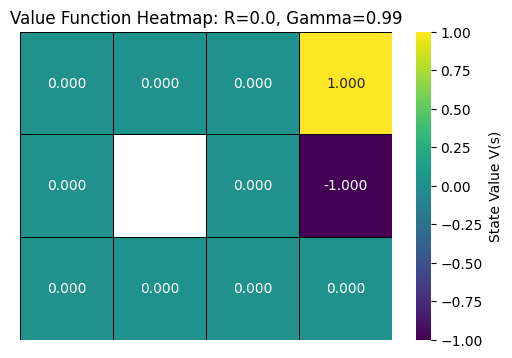

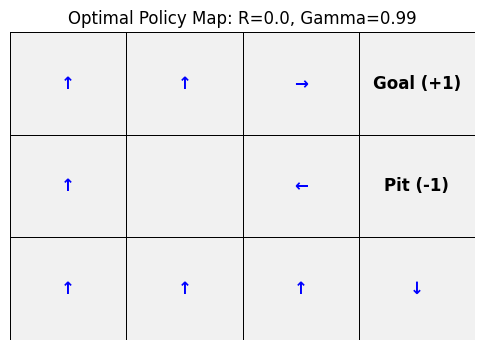


--- Running Pipeline: R=-0.5, Gamma=0.99 ---
Value Iteration converged after 16 iterations (max change: 0.000052)


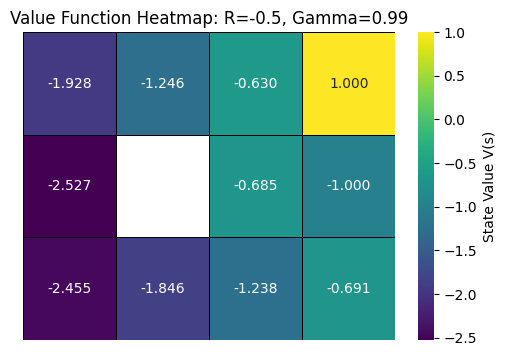

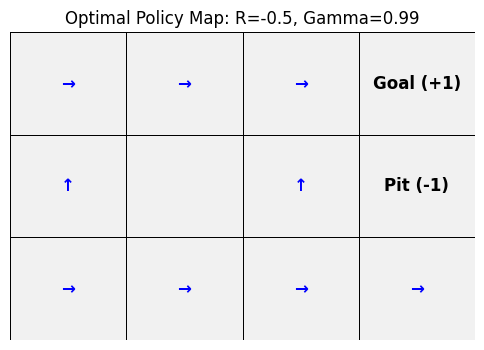

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any

# --- CONFIGURATION ---
# Define the grid dimensions
ROWS, COLS = 3, 4

# The grid map: 0=normal, 1=wall, 2=goal, 3=pit
GRID = np.array([
    [0, 0, 0, 2],
    [0, 1, 0, 3],
    [0, 0, 0, 0]
])

# Define states and actions
VALID_STATES = []
for r in range(ROWS):
    for c in range(COLS):
        if GRID[r, c] != 1:
            VALID_STATES.append((r, c))

TERMINAL_STATES = {(0, 3), (1, 3)}
ACTIONS = ['up', 'down', 'left', 'right']

# Mapping actions to (dr, dc)
ACTION_DELTAS = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}

# Default hyperparameters
DEFAULT_GAMMA = 0.99
DEFAULT_LIVING_PENALTY = -0.04

# --- TASK 1: MDP DEFINITION ---

def get_reward(state: Tuple[int, int], living_penalty: float) -> float:
    """Returns the reward R(s) for being in a state s."""
    if state == (0, 3):
        return 1.0 # Goal
    elif state == (1, 3):
        return -1.0 # Pit (using -1.0 as the danger reward)
    else:
        return living_penalty # Living penalty

def get_next_states(state: Tuple[int, int], action: str) -> List[Tuple[float, Tuple[int, int]]]:
    """
    Returns a list of (probability, next_state) tuples (Transition Model T).
    80% intended, 10% slip left, 10% slip right.
    """
    if state in TERMINAL_STATES:
        return [(1.0, state)]

    intended_delta = ACTION_DELTAS[action]
    dr, dc = intended_delta

    # Calculate deltas for 90-degree slips
    slip_left_delta = (dc, -dr)
    slip_right_delta = (-dc, dr)

    transitions = [
        (intended_delta, 0.8),
        (slip_left_delta, 0.1),
        (slip_right_delta, 0.1)
    ]

    transition_list = []

    for (dr_t, dc_t), prob in transitions:
        next_r, next_c = state[0] + dr_t, state[1] + dc_t
        next_state = (next_r, next_c)

        # Handle walls/boundaries (agent stays in current state)
        if next_r < 0 or next_r >= ROWS or next_c < 0 or next_c >= COLS or GRID[next_r, next_c] == 1:
            next_state = state

        transition_list.append((prob, next_state))

    return transition_list

# --- TASK 2: VALUE ITERATION ---

def value_iteration(
    states: List[Tuple[int, int]],
    actions: List[str],
    gamma: float,
    theta: float = 0.0001,
    living_penalty: float = DEFAULT_LIVING_PENALTY
) -> Dict[Tuple[int, int], float]:
    """Implements the Value Iteration algorithm."""

    V = {s: 0.0 for s in states}

    # Initialize terminal states values (R(s) is handled in the loop, but
    # fixing V[s] to 0 helps the Bellman equation handle terminals smoothly).
    V[(0, 3)] = 0.0
    V[(1, 3)] = 0.0

    iteration = 0
    while True:
        delta = 0
        V_new = V.copy()

        for s in states:
            if s in TERMINAL_STATES:
                continue

            v_old = V[s]

            # Bellman Optimality Equation: max_a Q(s, a)
            q_values = []

            for a in actions:
                expected_value = 0

                # Sum over all next states s'
                for prob, s_prime in get_next_states(s, a):
                    expected_value += prob * V[s_prime]

                # Q(s, a) = R(s) + gamma * expected_value
                R_s = get_reward(s, living_penalty)
                q_s_a = R_s + gamma * expected_value
                q_values.append(q_s_a)

            V_new[s] = np.max(q_values)

            delta = max(delta, abs(V_new[s] - v_old))

        V = V_new
        iteration += 1

        if delta < theta:
            print(f"Value Iteration converged after {iteration} iterations (max change: {delta:.6f})")
            break

    # Final value function needs the true reward for terminal states
    V[(0, 3)] = get_reward((0, 3), living_penalty) # Goal: 1.0
    V[(1, 3)] = get_reward((1, 3), living_penalty) # Pit: -1.0

    return V

# --- TASK 3: POLICY EXTRACTION ---

def extract_optimal_policy(
    V: Dict[Tuple[int, int], float],
    states: List[Tuple[int, int]],
    actions: List[str],
    gamma: float,
    living_penalty: float = DEFAULT_LIVING_PENALTY
) -> Dict[Tuple[int, int], str]:
    """Extracts the optimal policy Pi from the converged value function V."""

    Pi = {}

    for s in states:
        if s in TERMINAL_STATES:
            Pi[s] = 'Exit'
            continue

        best_action = None
        max_q_value = -np.inf

        for a in actions:
            expected_value = 0

            # Calculate E[V(s')] using the full V table
            for prob, s_prime in get_next_states(s, a):
                expected_value += prob * V[s_prime]

            # Q(s, a) = R(s) + gamma * E[V(s')]
            R_s = get_reward(s, living_penalty)
            q_s_a = R_s + gamma * expected_value

            if q_s_a > max_q_value:
                max_q_value = q_s_a
                best_action = a

        Pi[s] = best_action

    return Pi

# --- TASK 4: VISUALIZATION UTILITIES (CORRECTED) ---

def map_to_grid(data_dict: Dict[Tuple[int, int], Any], default_val: Any = np.nan) -> np.ndarray:
    """
    Converts a state-keyed dictionary to a 3x4 NumPy array.
    Uses a numeric placeholder (0.0) for wall cells for proper float conversion.
    """
    grid_data = np.full((ROWS, COLS), default_val, dtype=object)
    for r in range(ROWS):
        for c in range(COLS):
            state = (r, c)
            if state in data_dict:
                grid_data[r, c] = data_dict[state]
            elif GRID[r, c] == 1:
                 # Assign 0.0 placeholder for wall state
                 grid_data[r, c] = 0.0
    return grid_data

def visualize_value_function(V: Dict[Tuple[int, int], float], title: str):
    """Visualizes the Value function V as a heatmap."""

    v_grid = map_to_grid(V, default_val=0.0)
    v_grid = v_grid.astype(float) # Conversion now succeeds
    v_grid[GRID == 1] = np.nan # Hide wall

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        v_grid,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=.5,
        linecolor='black',
        cbar_kws={'label': 'State Value V(s)'}
    )
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    #

def visualize_policy(Pi: Dict[Tuple[int, int], str], title: str):
    """Visualizes the Policy Pi using arrows."""

    arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', 'Exit': 'E'}
    Pi_arrows = {s: arrow_map.get(a, 'E') for s, a in Pi.items()}
    pi_grid = map_to_grid(Pi_arrows, default_val='W') # W for Wall placeholder

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(
        np.zeros((ROWS, COLS)), # Neutral base
        annot=False, # We handle annotations manually
        fmt='s',
        cmap=sns.light_palette("lightgray", as_cmap=True),
        cbar=False,
        linewidths=.5,
        linecolor='black'
    )

    # Custom annotations for clarity
    for i in range(ROWS):
        for j in range(COLS):
            state = (i, j)
            if state in Pi_arrows:
                text = Pi_arrows[state]
                color = 'blue' if text in ['↑', '↓', '←', '→'] else 'black'

                # Special labels for terminals and wall
                if state == (0, 3): text = 'Goal (+1)'
                elif state == (1, 3): text = 'Pit (-1)'
                elif GRID[i, j] == 1: text = 'WALL'

                ax.text(j + 0.5, i + 0.5, text,
                        ha='center', va='center', color=color, fontsize=12, weight='bold')

    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    #

# --- MAIN RUNNER FUNCTION ---

def run_pipeline(gamma: float, living_penalty: float, title: str):
    """Runs the full Value Iteration pipeline and visualizations."""
    print(f"\n--- Running Pipeline: {title} ---")

    # 1. Value Iteration
    V = value_iteration(VALID_STATES, ACTIONS, gamma, living_penalty=living_penalty)

    # 2. Policy Extraction
    Pi = extract_optimal_policy(V, VALID_STATES, ACTIONS, gamma, living_penalty=living_penalty)

    # 3. Visualization
    visualize_value_function(V, f"Value Function Heatmap: {title}")
    visualize_policy(Pi, f"Optimal Policy Map: {title}")

    return V, Pi

# --- EXECUTION ---

# Question 1: Default Parameters (R=-0.04, Gamma=0.99)
V_default, Pi_default = run_pipeline(
    gamma=DEFAULT_GAMMA,
    living_penalty=DEFAULT_LIVING_PENALTY,
    title=f"R={DEFAULT_LIVING_PENALTY}, Gamma={DEFAULT_GAMMA}"
)

# Question 2: Zero Living Penalty (R=0.0)
V_zero, Pi_zero = run_pipeline(
    gamma=DEFAULT_GAMMA,
    living_penalty=0.0,
    title=f"R=0.0, Gamma={DEFAULT_GAMMA}"
)

# Question 3: High Living Penalty (R=-0.5)
V_high_penalty, Pi_high_penalty = run_pipeline(
    gamma=DEFAULT_GAMMA,
    living_penalty=-0.5,
    title=f"R=-0.5, Gamma={DEFAULT_GAMMA}"
)